In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scanpy as sc
import scipy

from importlib import reload

# TS Fib data

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/geneformer_adata/merged.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 166703 × 19311
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'cell_type', 'Barcode', 'Library', 'dataset', 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'HLF', 'CRHBP', 'CD34', 'MitoCoverage', 'ClonalGroup', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'meanCov', 'ClonalGroup.Prob', 'wsnn_res.0.8', 'Origin.Seurat'
    var: 'gene_name', 'ensemble_id'

In [21]:
fdata = adata[adata.obs['dataset'] == 'tabula_sapiens', :].copy()
fdata = fdata[fdata.obs['cell_type'] == "FB", :]

fdata.var_names = fdata.var['gene_name'].values

sc.pp.normalize_total(fdata)
sc.pp.log1p(fdata)

fdata

AnnData object with n_obs × n_vars = 26586 × 19311
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'cell_type', 'Barcode', 'Library', 'dataset', 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'HLF', 'CRHBP', 'CD34', 'MitoCoverage', 'ClonalGroup', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'meanCov', 'ClonalGroup.Prob', 'wsnn_res.0.8', 'Origin.Seurat'
    var: 'gene_name', 'ensemble_id'
    uns:

# Anthony's Data

In [22]:
# load BJ data
bj = pd.read_csv("/nfs/turbo/umms-indikar/shared/projects/R01/BJ_FIB_GENES.csv")
bj = bj.sort_values(by='tpm', ascending=False)
print(f"{bj.shape=}")

bj.head()

bj.shape=(19129, 5)


,gene_name,tpm,log_tpm,rank,is_panglao_marker
0,TMSB10,45584.16,10.727338,1.0,False
1,S100A6,35129.31,10.466820,2.0,False
2,LGALS1,22412.13,10.017402,3.0,False
3,TMSB4X,15365.34,9.639935,4.0,False
4,MYL6,14625.02,9.590557,5.0,False


# Compare Anthony to TS

In [23]:
res = []
for tissue, group in fdata.obs.groupby('organ_tissue'):
    X = fdata[group.index, :].copy().to_df()
    print(f"{tissue} {X.shape=}") 
    
    X = X.mean(axis=0).reset_index()
    X.columns = ['gene_name', tissue]
    
    X = pd.merge(X, bj)
    
    # all correlation
    r_all, pval_all = scipy.stats.pearsonr(X[tissue].values, 
                                           X['log_tpm'].values,
                                          )
    
    # FB marker correlation
    X = X[X['is_panglao_marker']]
    r_markers, pval_markers = scipy.stats.pearsonr(X[tissue].values, 
                                   X['log_tpm'].values,
                                  )
    row = {
        'tissue' : tissue.replace("_", " "),
        'r_all' : r_all,
        'pval_all' : pval_all,
        'r_markers' : r_markers,
        'pval_markers' : pval_markers,
    }
    res.append(row)
    
res = pd.DataFrame(res)
res

/tmp/ipykernel_2261064/1688001700.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for tissue, group in fdata.obs.groupby('organ_tissue'):


Bladder X.shape=(5557, 19311)
Fat X.shape=(8459, 19311)
Large_Intestine X.shape=(953, 19311)
Prostate X.shape=(223, 19311)
Small_Intestine X.shape=(113, 19311)
Thymus X.shape=(3924, 19311)
Tongue X.shape=(251, 19311)
Trachea X.shape=(1239, 19311)
Vasculature X.shape=(5867, 19311)


,tissue,r_all,pval_all,r_markers,pval_markers
0,Bladder,0.596032,0.0,0.526109,2.907257e-11
1,Fat,0.598906,0.0,0.546810,3.307963e-12
2,Large Intestine,0.545897,0.0,0.369587,7.548751e-06
3,Prostate,0.596991,0.0,0.429011,1.368794e-07
4,Small Intestine,0.593430,0.0,0.471787,4.555615e-09
5,Thymus,0.621174,0.0,0.525246,3.173042e-11
6,Tongue,0.582562,0.0,0.537050,9.387951e-12
7,Trachea,0.629629,0.0,0.549916,2.356662e-12
8,Vasculature,0.619551,0.0,0.527169,2.610236e-11


Text(0.5, 1.0, 'BJ Correlation w/ Tabula Sapiens')

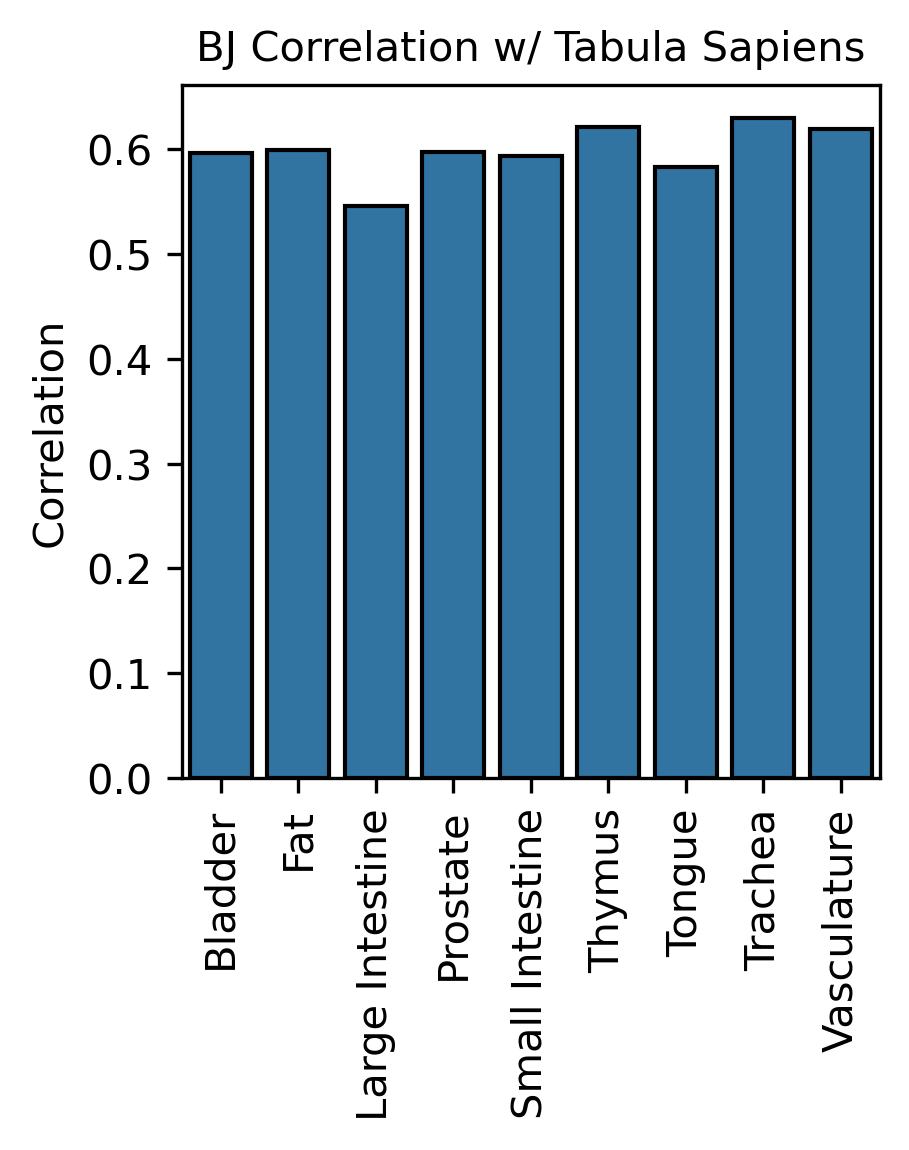

In [24]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

sns.barplot(data=res, 
            x='tissue',
            y='r_all',
            ec='k')

plt.ylabel('Correlation')
plt.xlabel('')
plt.gca().tick_params(axis='x', rotation=90)
plt.title("BJ Correlation w/ Tabula Sapiens", fontsize=10)

In [ ]:
break

Text(0.5, 1.0, 'BJ Correlation w/ Tabula Sapiens \n (FB Markers Only)')

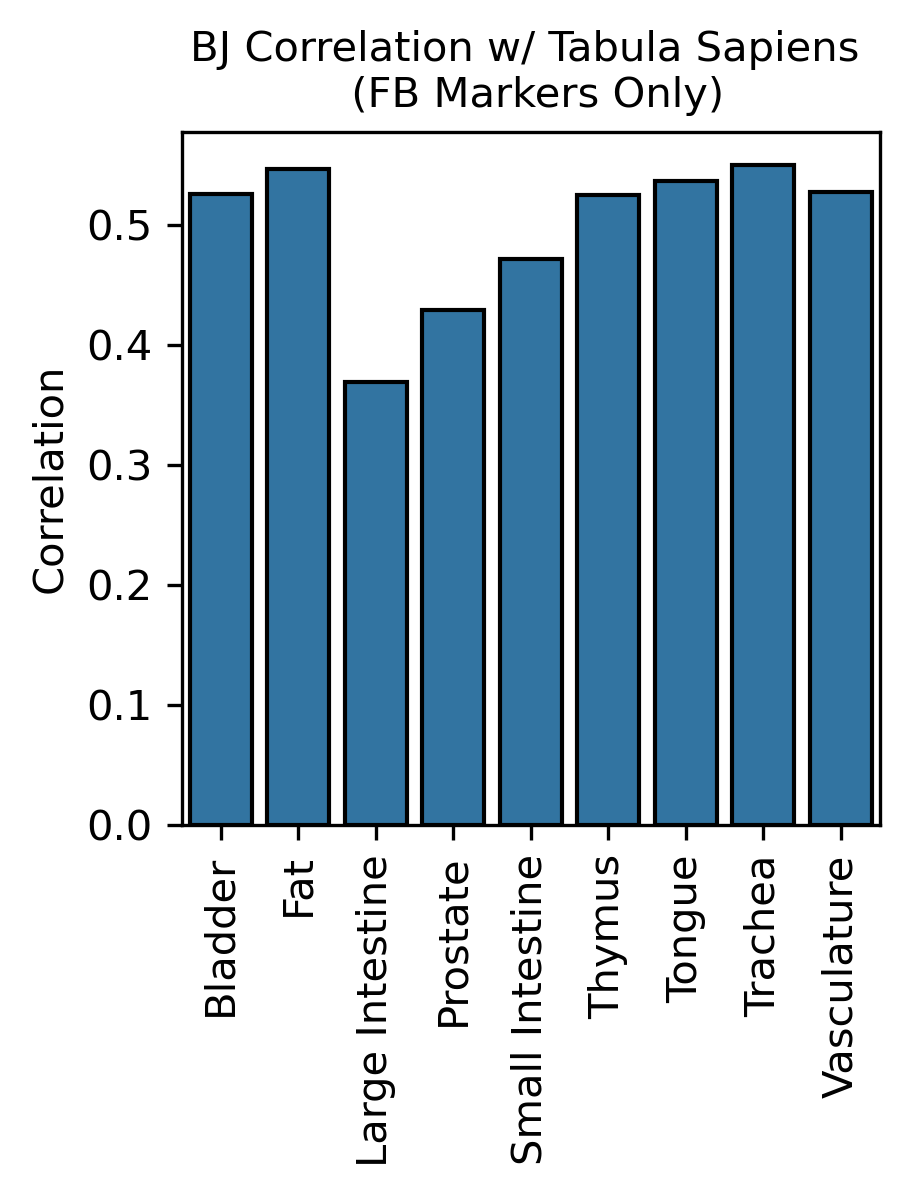

In [25]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

sns.barplot(data=res, 
            x='tissue',
            y='r_markers',
            ec='k')

plt.ylabel('Correlation')
plt.xlabel('')
plt.gca().tick_params(axis='x', rotation=90)
plt.title("BJ Correlation w/ Tabula Sapiens \n (FB Markers Only)", fontsize=10)

# All together now!

In [26]:
liu = pd.read_csv("/nfs/turbo/umms-indikar/shared/projects/R01/2015_tpm.csv")
liu = liu[liu['control'] == 'control']

liu = pd.pivot_table(liu, 
                      index='gene_name',
                      columns='time_point',
                      values='tpm',
                      )

liu = liu.mean(axis=1).reset_index()
liu.columns = ['gene_name', 'liu_fibroblast_2018']
liu['liu_fibroblast_2018'] = np.log1p(liu['liu_fibroblast_2018'])
liu.head()

,gene_name,liu_fibroblast_2018
0,A1BG,0.134265
1,A1CF,0.000000
2,A2M,0.000000
3,A2ML1,0.000000
4,A3GALT2,0.000000


In [27]:
chen = pd.read_csv("/nfs/turbo/umms-indikar/shared/projects/R01/2015_tpm.csv")
chen = pd.pivot_table(chen, 
                      index='gene_name',
                      columns='time_point',
                      values='tpm',
                      )

chen = chen.mean(axis=1).reset_index()
chen.columns = ['gene_name', 'chen_fibroblast_2015']
chen['chen_fibroblast_2015'] = np.log1p(chen['chen_fibroblast_2015'])
chen.head()

,gene_name,chen_fibroblast_2015
0,A1BG,0.070114
1,A1CF,0.000482
2,A2M,0.000773
3,A2ML1,0.000232
4,A3GALT2,0.000000


In [52]:
df = pd.merge(chen, liu, 
              how='inner',
              on='gene_name').fillna(0)

df = pd.merge(df, bj[['gene_name', 'log_tpm']],  
              how='inner',
              on='gene_name').fillna(0)

df = df.rename(columns={'log_tpm' : 'ac_bj_fibroblast'})
outpath = "/nfs/turbo/umms-indikar/shared/projects/R01/merged_fib_data.csv"
df.to_csv(outpath, index=False)
df.head()

,gene_name,chen_fibroblast_2015,liu_fibroblast_2018,ac_bj_fibroblast
0,A1BG,0.070114,0.134265,4.414373
1,A1CF,0.000482,0.000000,0.000000
2,A2M,0.000773,0.000000,2.748552
3,A2ML1,0.000232,0.000000,0.076961
4,A3GALT2,0.000000,0.000000,0.000000


In [41]:
# all correlation
r_all, pval_all = scipy.stats.pearsonr(df['chen_fibroblast_2015'].values, 
                                       df['ac_bj_fibroblast'].values,
                                      )

print(f"r={r_all:.3f}, (p={pval_all:.5f})")

# all correlation
r_all, pval_all = scipy.stats.pearsonr(df['liu_fibroblast_2018'].values, 
                                       df['ac_bj_fibroblast'].values,
                                      )

print(f"r={r_all:.3f}, (p={pval_all:.5f})")

r=0.532, (p=0.00000)
r=0.522, (p=0.00000)


<Axes: >

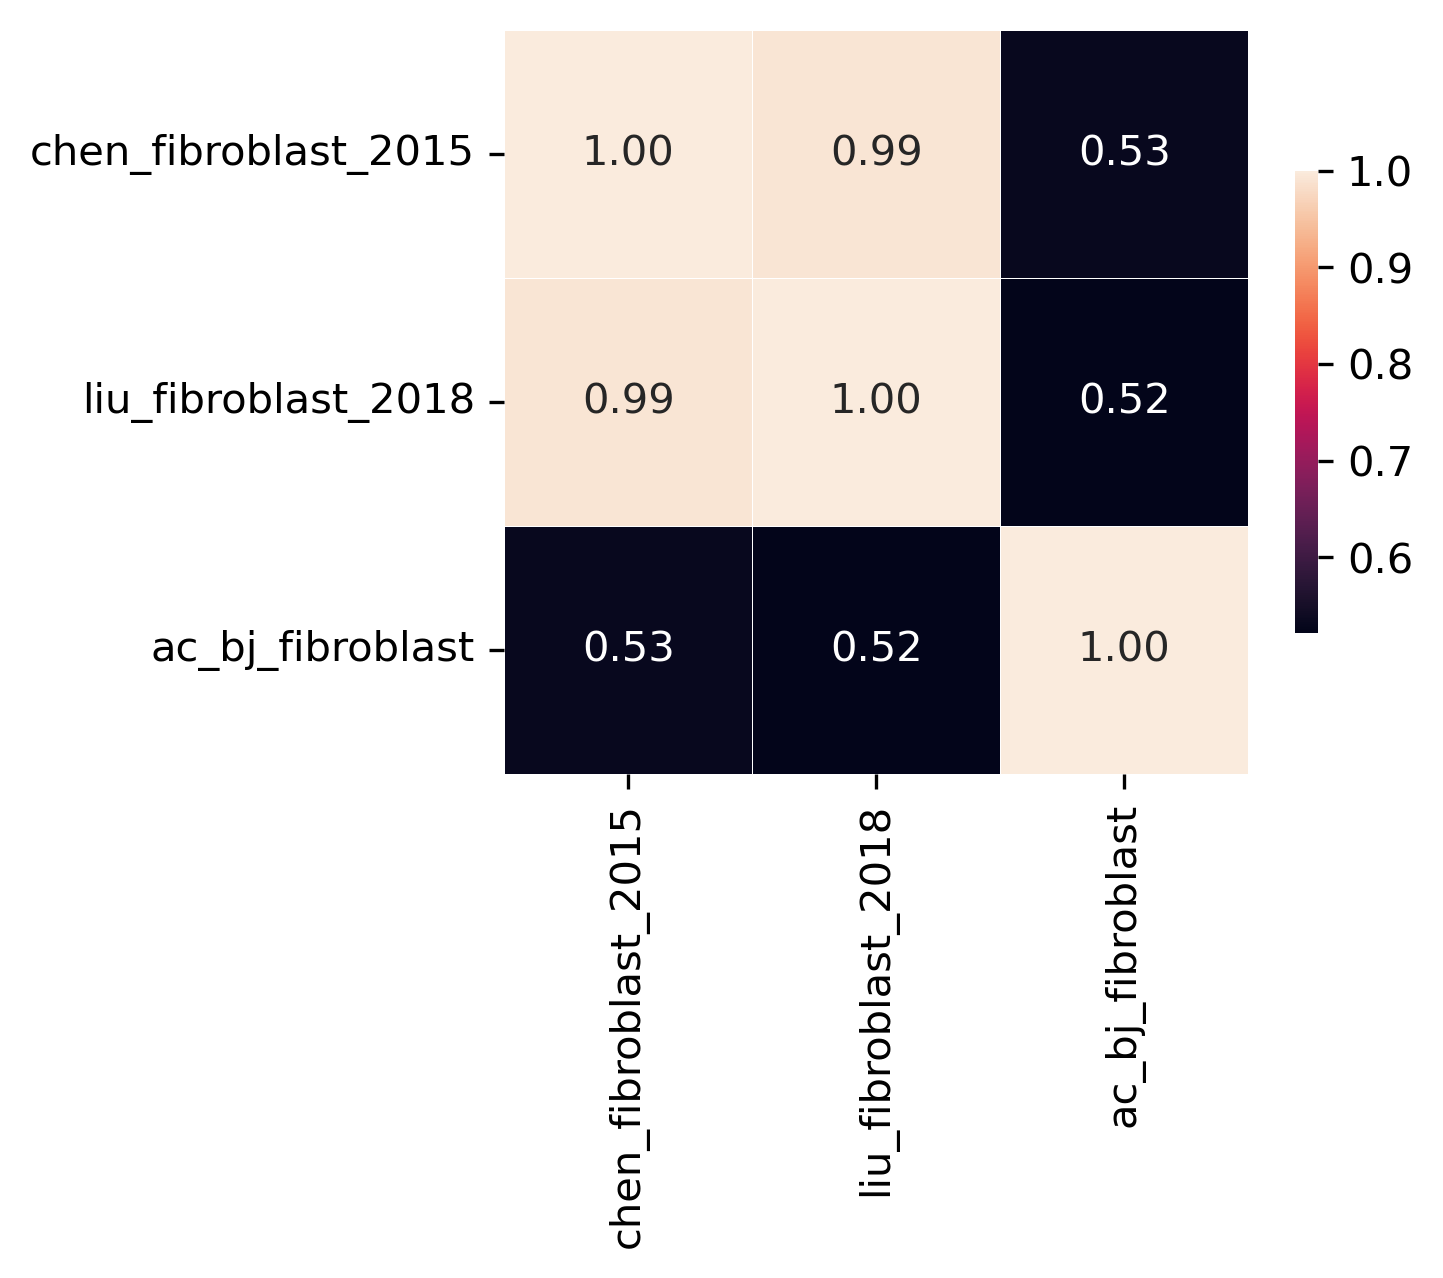

In [42]:
X = df.set_index('gene_name')
X = X.corr()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sns.heatmap(X, lw=0.2,
            square=True, 
            annot=True,
            fmt=".2f",
            cbar_kws={'shrink' : 0.5})

In [43]:
for tissue, group in fdata.obs.groupby('organ_tissue'):
    X = fdata[group.index, :].copy().to_df()
    print(f"{tissue} {X.shape=}") 
    
    X = X.mean(axis=0).reset_index()
    X.columns = ['gene_name', tissue]
    
    df = pd.merge(df, X, how='left',
                  left_on='gene_name',
                  right_on='gene_name',)

df = df.fillna(0)
df = df.set_index('gene_name')
print(f"{df.shape=}")

# drop universally zero expressing genes (701 genes)
df = df[df.sum(axis=1) != 0]
df.head()

/tmp/ipykernel_2261064/2025989730.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for tissue, group in fdata.obs.groupby('organ_tissue'):


Bladder X.shape=(5557, 19311)
Fat X.shape=(8459, 19311)
Large_Intestine X.shape=(953, 19311)
Prostate X.shape=(223, 19311)
Small_Intestine X.shape=(113, 19311)
Thymus X.shape=(3924, 19311)
Tongue X.shape=(251, 19311)
Trachea X.shape=(1239, 19311)
Vasculature X.shape=(5867, 19311)
df.shape=(18988, 12)


,chen_fibroblast_2015,liu_fibroblast_2018,ac_bj_fibroblast,Bladder,Fat,Large_Intestine,Prostate,Small_Intestine,Thymus,Tongue,Trachea,Vasculature
gene_name,,,,,,,,,,,,
A1BG,0.070114,0.134265,4.414373,0.001566,0.004668,0.001091,0.015745,0.005942,0.009392,0.015032,0.000000,0.006205
A1CF,0.000482,0.000000,0.000000,0.000182,0.000050,0.006861,0.000000,0.009119,0.000000,0.000000,0.000000,0.000163
A2M,0.000773,0.000000,2.748552,0.506570,0.222712,0.537395,0.860574,0.995174,0.646448,0.298271,0.551391,0.520899
A2ML1,0.000232,0.000000,0.076961,0.000905,0.000441,0.000000,0.000000,0.000000,0.001345,0.231460,0.001439,0.001362
A3GALT2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.000000


<Axes: >

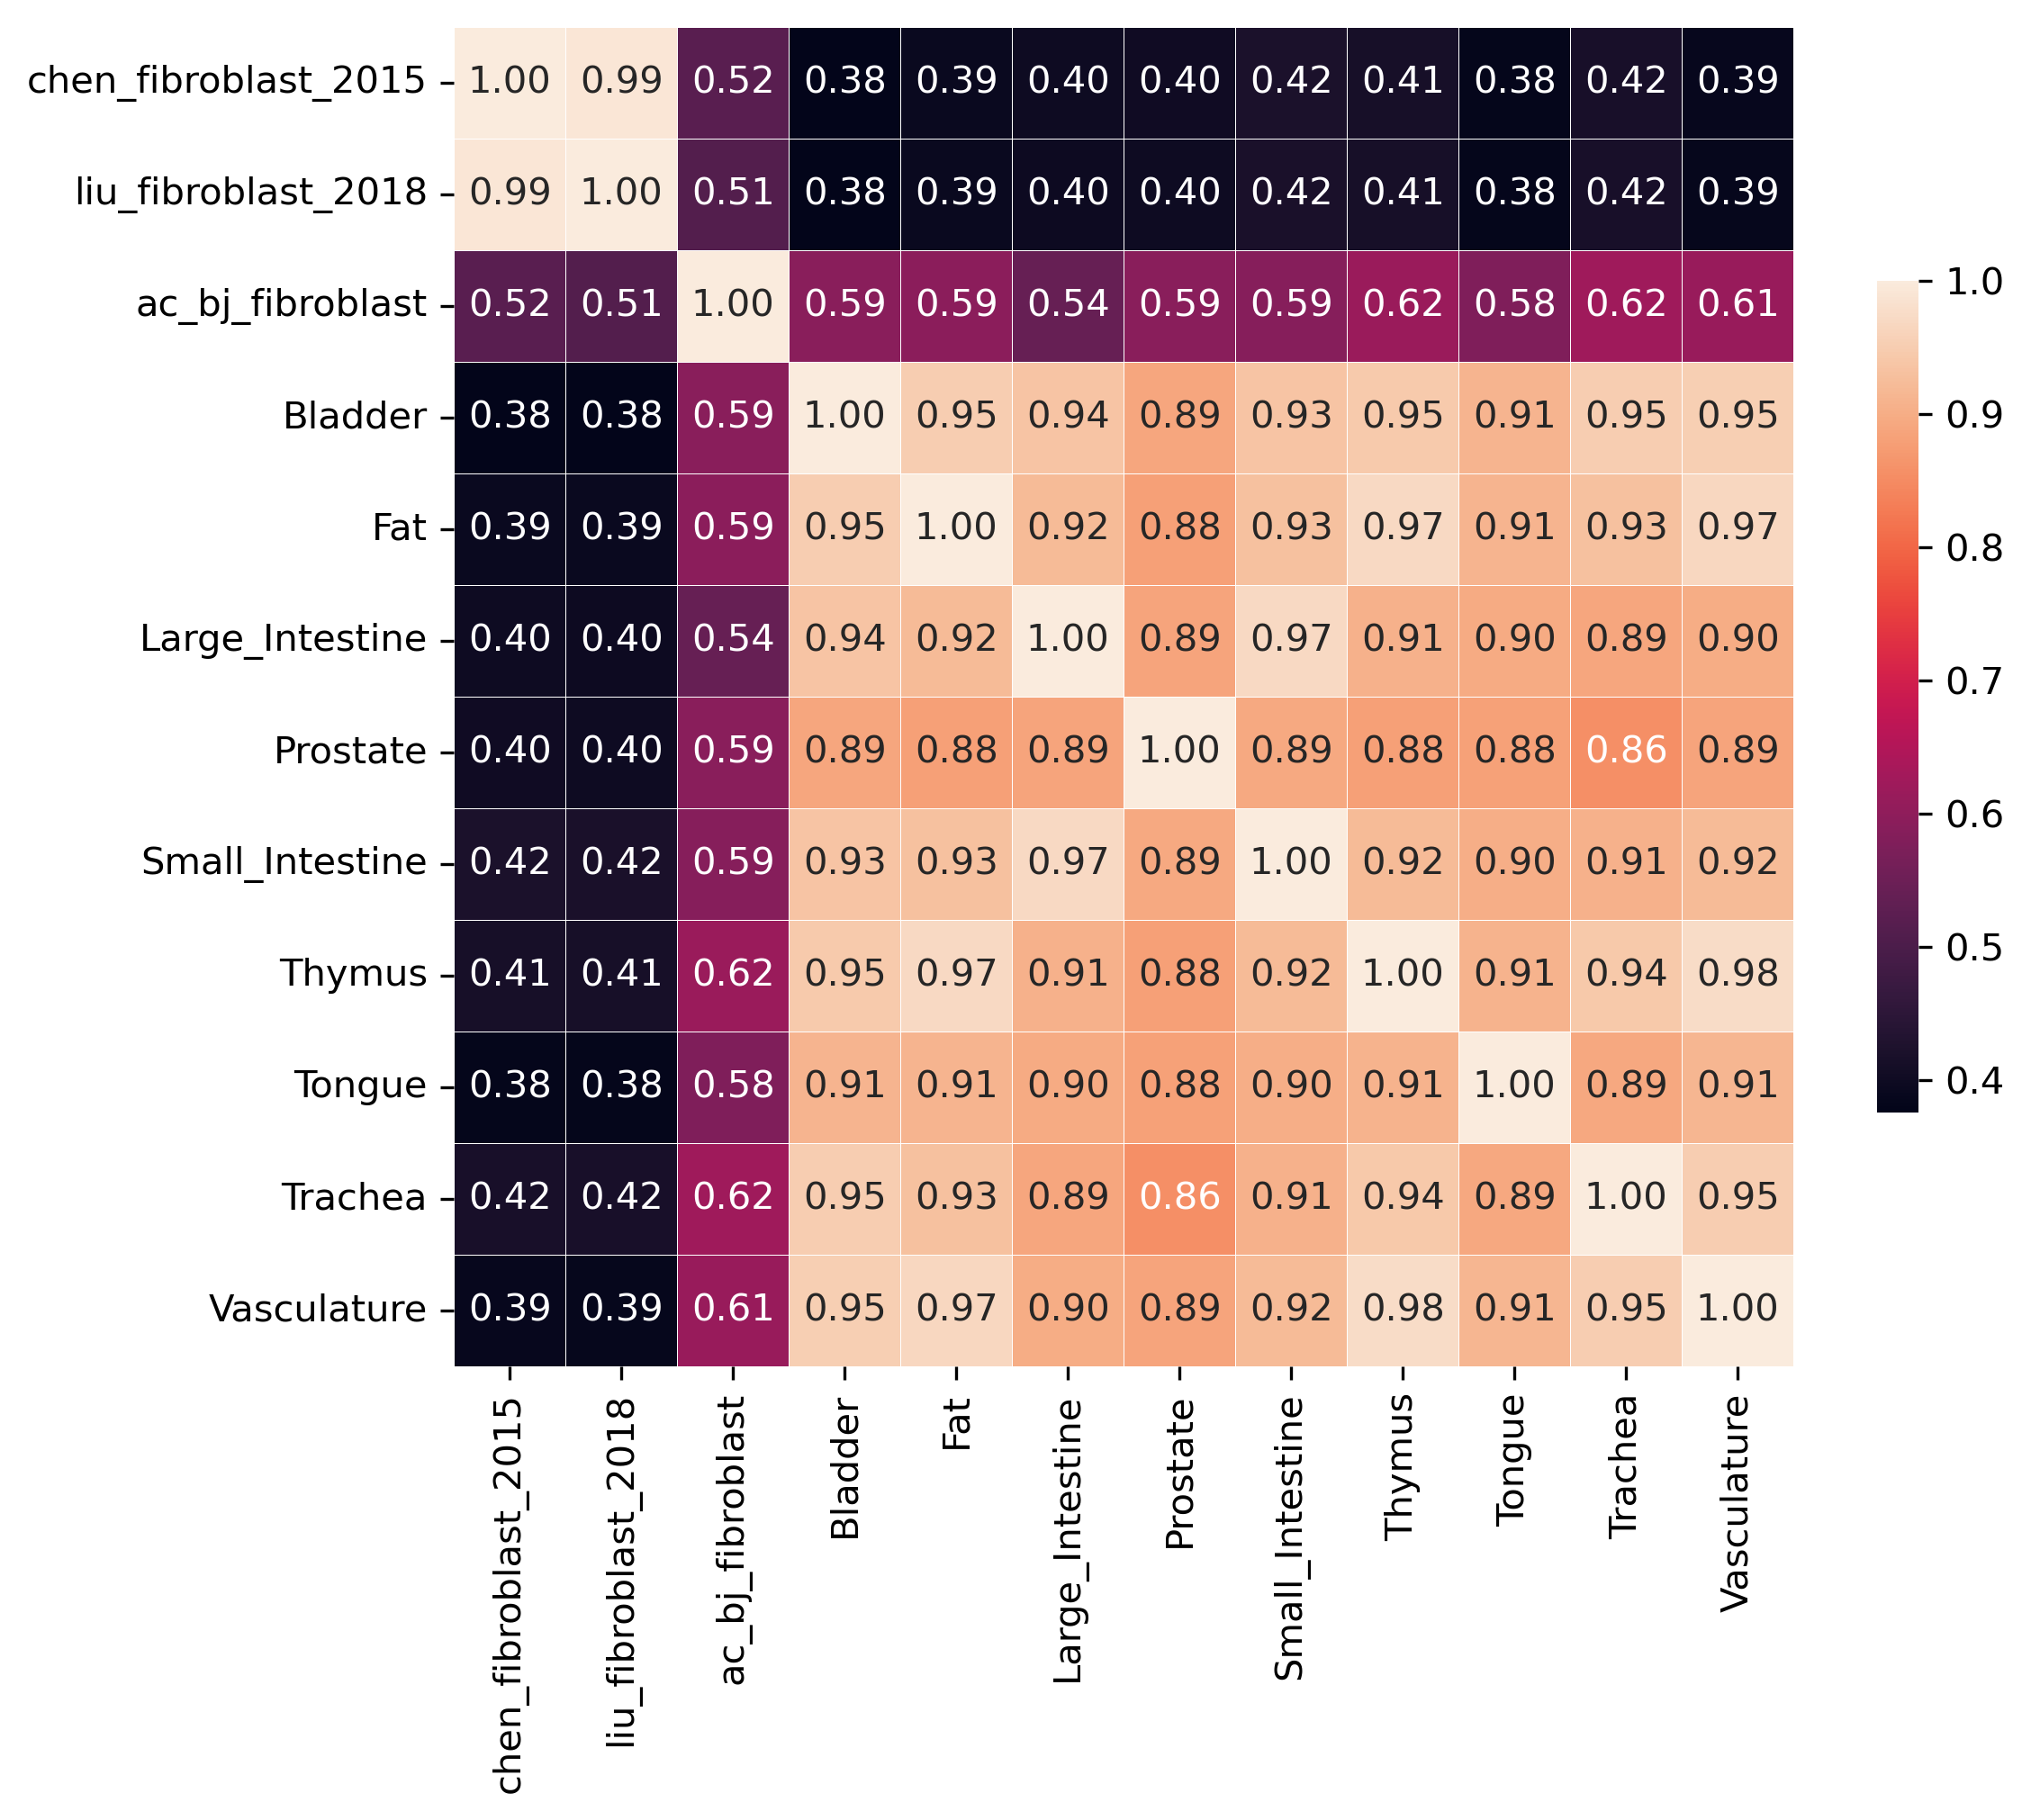

In [44]:
X = df.corr()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 8

sns.heatmap(X, lw=0.2,
            square=True, 
            annot=True,
            fmt=".2f",
            cbar_kws={'shrink' : 0.5})

<Axes: >

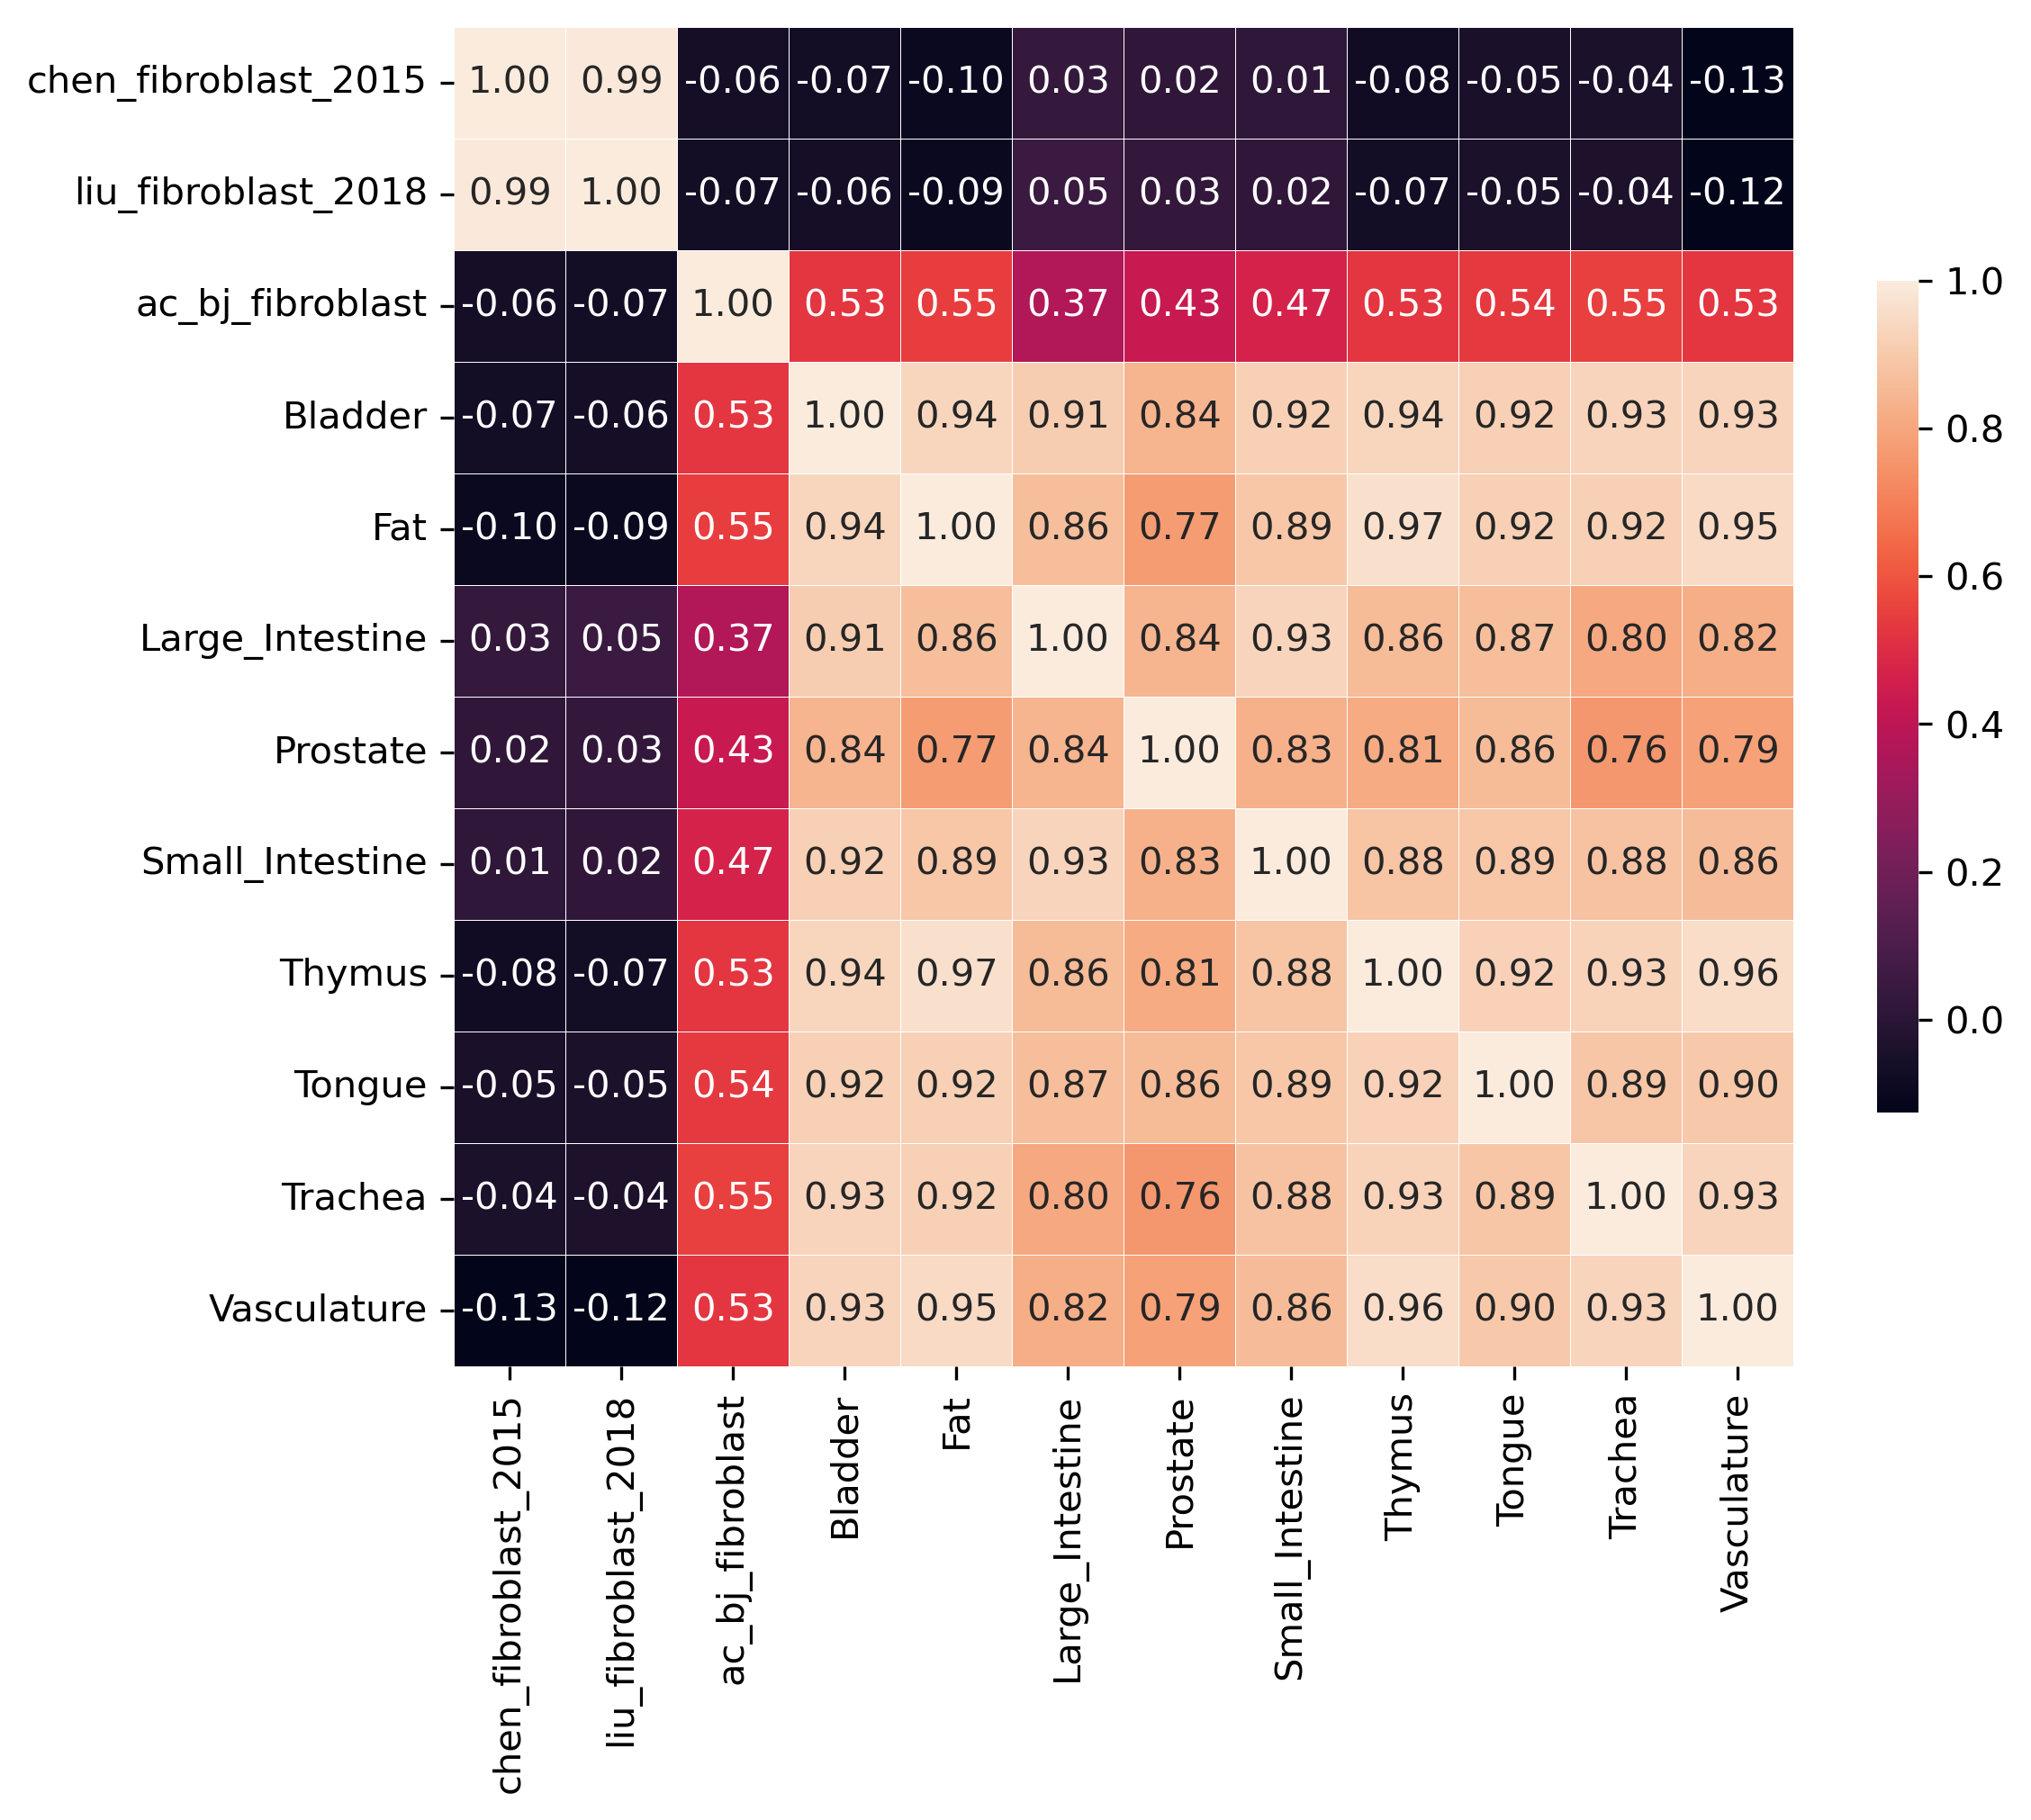

In [50]:
marker = bj[bj['is_panglao_marker']]['gene_name'].values
mask = np.isin(df.index, marker)

X = df[mask].corr()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 8

sns.heatmap(X, lw=0.2,
            square=True, 
            annot=True,
            fmt=".2f",
            cbar_kws={'shrink' : 0.5})